In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install roboflow

In [ ]:
# from roboflow import Roboflow
# import os

# rf = Roboflow(api_key="E6klOjeOgdAuTJyFXCpD")
# project = rf.workspace("objectdetection").project('reid-b9lox')

# dataset_path = "/kaggle/input/reid-dataset/dataset_ETHZ/seq1"

# for folder_name in os.listdir(dataset_path):
#     folder_path = os.path.join(dataset_path, folder_name)
#     if os.path.isdir(folder_path):
#         for image_file in os.listdir(folder_path):
#             if image_file.endswith((".jpg", ".png")): 
#                 image_path = os.path.join(folder_path, image_file)
#                 project.single_upload(
#                     image_path=image_path,
#                     tag_names=[folder_name]  # Dùng tên folder làm class
#                 )
#                 print(f"Uploaded {image_file} from {folder_name}")

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

In [24]:

# Đường dẫn đến dữ liệu từ Roboflow
data_dir = "/kaggle/input/reid-dataset/dataset_ETHZ/seq1"  # Thay bằng thư mục sau khi giải nén (chứa train/valid/test)

# Transform dữ liệu cho MobileNetV2
transformation = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=data_dir, transform=transformation)
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True,  num_workers=4)

In [25]:
# Tải MobileNetV2 với trọng số pre-trained từ ImageNet
model = models.mobilenet_v2(pretrained=True)

# Đóng băng các layer của mô hình (chỉ huấn luyện lớp fully connected)
for param in model.parameters():
    param.requires_grad = False

# Thay lớp fully connected để phù hợp với 83 class
model.classifier[1] = nn.Sequential(nn.Linear(model.last_channel, 128), nn.Linear(128, 83))


# Chuyển model sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_data_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [27]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [28]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []

# Train over 20 epochs (in a real scenario, you'd likely use many more)
epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_data_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)


Epoch: 1
Training set [0/4857 (0%)] Loss: 4.459498
Training set [320/4857 (7%)] Loss: 3.963038
Training set [640/4857 (13%)] Loss: 3.425424
Training set [960/4857 (20%)] Loss: 3.615683
Training set [1280/4857 (26%)] Loss: 3.627561
Training set [1600/4857 (33%)] Loss: 2.865065
Training set [1920/4857 (39%)] Loss: 2.784567
Training set [2240/4857 (46%)] Loss: 2.304363
Training set [2560/4857 (53%)] Loss: 2.105062
Training set [2880/4857 (59%)] Loss: 2.092680
Training set [3200/4857 (66%)] Loss: 2.222371
Training set [3520/4857 (72%)] Loss: 1.780229
Training set [3840/4857 (79%)] Loss: 1.680151
Training set [4160/4857 (86%)] Loss: 1.788515
Training set [4480/4857 (92%)] Loss: 0.958950
Training set [4800/4857 (99%)] Loss: 1.201260
Training set: Average loss: 2.546337
Epoch: 2
Training set [0/4857 (0%)] Loss: 1.277029
Training set [320/4857 (7%)] Loss: 0.774886
Training set [640/4857 (13%)] Loss: 1.028592
Training set [960/4857 (20%)] Loss: 1.338444
Training set [1280/4857 (26%)] Loss: 0.86

Text(0, 0.5, 'Loss value')

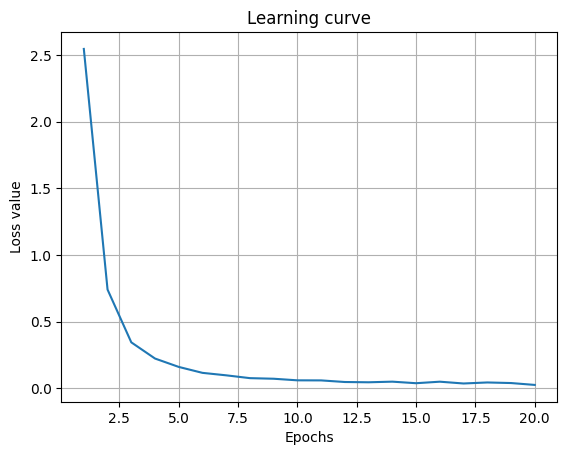

In [30]:
plt.plot(epoch_nums, training_loss)
plt.grid('True')
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss value')

In [33]:
model_path = '/kaggle/working/reid_weights.pt'
torch.save(model, model_path)

In [34]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [36]:
pretrained_model = torch.load('/kaggle/working/reid_weights.pt')
pretrained_model

<ipython-input-36-6899f5ea3402>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load('/kaggle/working/reid_weights.pt')


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=